In [166]:
!pip install google-cloud-storage MedPy onedrivedownloader

In [167]:
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

working_dir = '/content/drive/My Drive/Capstone/BioCV_Su23/src'
os.chdir(working_dir)

Mounted at /content/drive


In [213]:
import joblib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time

# Custom modules
import utils.mri_plotter as mrp
import utils.mri_common as mri_common
import utils.metrics as metrics

from utils.data_handler import DataHandler, StructuralScan, MriType
from utils.mri_plotter import MRIPlotter
mri_plt = MRIPlotter()

#### INITALIZE VARIABLES

In [214]:
RECALCULATE = False
data_handler = DataHandler()

# mri_type_annotated = MriType.ANNOTATED
# mri_type_segmented = MriType.AUTO_SEGMENTED
# mri_type_struct = MriType.STRUCT_SCAN

# worst_dice_file_name = "worst_dice.joblib"
# worst_hd_file_name = "worst_hd95.joblib"
# scores_file = "variables.joblib"

mri_type_annotated = MriType.ANNOTATED_REDUCED
mri_type_segmented = MriType.AUTO_SEGMENTED_REDUCED
mri_type_struct = MriType.STRUCT_SCAN_REDUCED

worst_dice_file_name = "worst_dice-2.joblib"
worst_hd_file_name = "worst_hd95-2.joblib"
scores_file = "variables-2.joblib"

In [215]:
struct_files = data_handler.list_mri_in_dir(mri_type=mri_type_struct)

# if using reduce, make sure to include only those with _segm
annot_files = data_handler.list_mri_in_dir(mri_type=mri_type_annotated)
annot_files = [file for file in annot_files if "_segm" in file]

auto_segm_files = data_handler.list_mri_in_dir(mri_type=mri_type_segmented)

print("Struct Files", len(struct_files))
print("Annotated Files", len(annot_files))
print("Auto Segmented Files", len(auto_segm_files))

Struct Files 735
Annotated Files 147
Auto Segmented Files 147


### HELPER FUNCTIONS FOR PLOTTING

In [216]:
segment_ids = list(mri_common.SEGMENTS.keys())
segment_names = np.array(list(mri_common.SEGMENTS.values()))
segment_colors = np.array(list(mri_common.SEGMENT_COLORS.values()))

In [257]:
def get_nonzero_extents(arr):
  if not np.any(arr != 0):
    center = np.array(arr.shape) // 2
    minima = center - 1
    maxima = center + 1
    return minima, maxima
  else:
    indices = np.where(arr != 0)
    minima = np.min(indices, axis=1)
    maxima = np.max(indices, axis=1)
    return minima, maxima

def get_bounds(true_img_bin, pred_img_bin):
  min1, max1 = get_nonzero_extents(true_img_bin)
  min2, max2 = get_nonzero_extents(pred_img_bin)
  combined_min = np.minimum(min1, min2)
  combined_max = np.maximum(max1, max2)

  adj_min = np.maximum(combined_min-20, 0)
  adj_max = np.minimum(combined_max+20, np.array(true_img_bin.shape) - 1)
  return adj_min, adj_max

def convert_none_to_zero(img):
    converted_array = np.where(img==None, 0, img)
    return converted_array.astype(float)

def zoom_image(img, adj_min, adj_max):
  return img[adj_min[0]:adj_max[0]+1, adj_min[1]:adj_max[1]+1, :]

def plot_samples(subj_files_np, top_samples, hd95=False):
  nrows=len(top_samples)
  ncols=3

  mri_plt = MRIPlotter()
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7*ncols, 6*nrows))

  for idx, img_info in enumerate(top_samples):

    subj_file_idx, segment_idx, hd95 = img_info

    subj_id = subj_files_np[subj_file_idx]
    segment_id = segment_ids[segment_idx]
    segment_name = segment_names[segment_idx]

    # load flair image as base image
    base_img = data_handler.load_mri(subj_id=subj_id,
                                mri_type=mri_type_struct,
                                struct_scan=StructuralScan.FLAIR)

    # load segmented and auto-segmented
    true_img = data_handler.load_mri(subj_id=subj_id,
                                mri_type=mri_type_annotated)
    pred_img = data_handler.load_mri(subj_id=subj_id,
                                mri_type=mri_type_segmented)

    # get binary mask for segment with lowest dice score
    true_img_bin = (true_img == segment_id)
    pred_img_bin = (pred_img == segment_id)

    # get appropriate slice from true image
    z_idx = mri_common.get_largest_tumor_slice_idx(true_img_bin)[0]

    if hd95 == True:
    # get all surface distance
      hd95, surface_dist_pred, surface_dist_true =  metrics.plot_hausdorff_95(pred_img, true_img, segment=segment_id)
      surface_dist_true_2 = convert_none_to_zero(surface_dist_true)

      # get appropriate slice from true image
      z_idx = mri_common.get_largest_tumor_slice_idx(surface_dist_true_2, sum=True)[0]


    # Column 1: plot base image FLAIR and predicted mask as overlay
    mri_plt.plot_struct_img(img_data=base_img, fig=fig, axs=axs, row=idx, col=0,
                            title=f"{subj_id} - Slice: {z_idx}", colorbar=False, slice_idx=z_idx)
    mri_plt.plot_segm_img(img_data=true_img, fig=fig, axs=axs, row=idx, col=0, overlay=True, slice_idx=z_idx)

    # Column 2: plot full mri scan with specific segment
    mri_plt.plot_struct_img(img_data=base_img, fig=fig, axs=axs, row=idx, col=1,
                            title=f"{subj_id}- {segment_name} - {round(hd95, 2)}",
                            colorbar=False, slice_idx=z_idx)
    mri_plt.plot_masks(masks=[true_img_bin[:, :, z_idx], pred_img_bin[:, :, z_idx]],
                legends=["input", "predicted"],
                title=segment_name,
                fig=fig, axs=axs, row=idx, col=1)

    # Column 3: plot zoomed view
    adj_min, adj_max = get_bounds(true_img_bin, pred_img_bin)
    base_zoomed = zoom_image(base_img.copy(), adj_min, adj_max)
    true_zoomed = zoom_image(true_img_bin.copy(), adj_min, adj_max)
    pred_zoomed = zoom_image(pred_img_bin.copy(), adj_min, adj_max)

    mri_plt.plot_struct_img(img_data=base_zoomed, fig=fig, axs=axs, row=idx, col=2,
                            title=f"{subj_id} - {segment_name} - {round(hd95, 2)}",
                            colorbar=False, slice_idx=z_idx)

    mri_plt.plot_masks(masks=[true_zoomed[:, :, z_idx], pred_zoomed[:, :, z_idx]],
                    legends=["input", "predicted"],
                    title=segment_name,
                    fig=fig, axs=axs, row=idx, col=2)
  plt.show()

### CALCULATE METRICS

In [218]:
def calc_metric_all_segments(segments, metric_func, *args, **kwargs):
  results = []
  for segment in segments:
    result = metric_func(*args, **kwargs, segm_id=segment)
    results.append(result)
  return results

In [219]:
all_common_metrics = []
all_dice = []
all_hd95 = []
all_missclass_per_label = []
all_true_per_label = []
error_files = []

In [220]:
# Calculate dice score one by one for each image to avoid out-of-memory issues
if RECALCULATE:
  start = time.time()

  subj_files = [annot_file.split("_")[0]+"_11" for annot_file in annot_files]
  for subj_id in subj_files:

    # load the segmented and auto segmented image of a file
    true_img = data_handler.load_mri(subj_id, mri_type=mri_type_annotated)
    pred_img = data_handler.load_mri(subj_id, mri_type=mri_type_segmented)
    try:
        print(f"Calculating metrics for {subj_id}")

        # metric 1: just count incorrect labels vs true labels for each file
        misclassified_per_label = []
        true_per_label = []
        for segment_id in segment_ids:
          true_count = np.sum(true_img == segment_id)
          pred_count = np.sum(pred_img == segment_id)

          count_difference = abs(true_count - pred_count)

          true_per_label.append(true_count)
          misclassified_per_label.append(count_difference)

        # metric 2: other common metrics
        common_metrics = calc_metric_all_segments(segment_ids, metrics.calc_binary_metrics, pred_img, true_img)
        common_metrics_dict = {}
        for key in common_metrics[0]:
            common_metrics_dict[key] = [metric[key] for metric in common_metrics]

        # metric 3: dice coefficient
        dice_score = calc_metric_all_segments(segment_ids, metrics.calc_dice_score, pred_img, true_img)

        # metric 4: 95% Hausdorff
        hausdorff_val =  calc_metric_all_segments(segment_ids, metrics.calc_hausdorff_95, pred_img, true_img)

        # append only when there is no error:
        all_dice.append(dice_score)
        all_hd95.append(hausdorff_val)
        all_missclass_per_label.append(misclassified_per_label)
        all_true_per_label.append(true_per_label)
        all_common_metrics.append(common_metrics_dict)
    except Exception as ex:
        print(f"Error {subj_id}", ex)
        error_files.append(subj_id)

  # remove error files from subj_files
  print("errors", error_files)
  subj_files = list(filter(lambda x: x not in error_files, subj_files))

  print(f"New length after removing problematic images: {len(subj_files)}")
  subj_files_np = np.array(subj_files)

  variables_dict = {'subj_files': subj_files,
                    'subj_files_np': subj_files_np,
                    'error_files': error_files,
                    'all_dice': all_dice,
                    'all_hd95': all_hd95,
                    'all_missclass_per_label': all_missclass_per_label,
                    'all_true_per_label': all_true_per_label,
                    'all_common_metrics': all_common_metrics}

  end = time.time()
  print("elapsed time", str(end - start))

  # Save locally via joblib. Running the entire calculation everytime takes time
  joblib.dump(variables_dict, os.path.join('training', scores_file))

## RESULTS

In [221]:
# Read results from local repo to save time
if RECALCULATE == False:
  variables_dict = joblib.load(os.path.join('training', scores_file))
  subj_files = variables_dict["subj_files"]
  subj_files_np = variables_dict["subj_files_np"]
  error_files = variables_dict["error_files"]
  all_dice = variables_dict["all_dice"]
  all_hd95 = variables_dict["all_hd95"]
  all_missclass_per_label = variables_dict["all_missclass_per_label"]
  all_true_per_label = variables_dict["all_true_per_label"]
  all_common_metrics = variables_dict["all_common_metrics"]

### COUNT DIFFERENCE/ TRUE COUNT

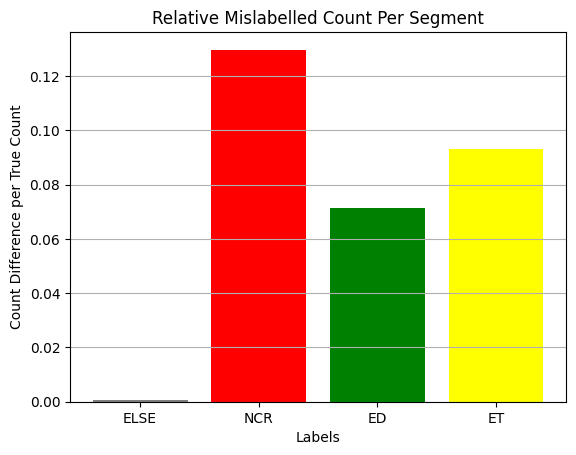

In [222]:
total_misclassifed = np.array(all_missclass_per_label).sum(axis = 0)
true_count = np.array(all_true_per_label).sum(axis = 0)
plt.bar(range(len(segment_ids)), total_misclassifed/true_count, color=segment_colors)
plt.xlabel('Labels')
plt.ylabel('Count Difference per True Count')
plt.title('Relative Mislabelled Count Per Segment')
plt.xticks(range(len(segment_ids)), segment_names)
plt.grid(axis="y")
plt.show()

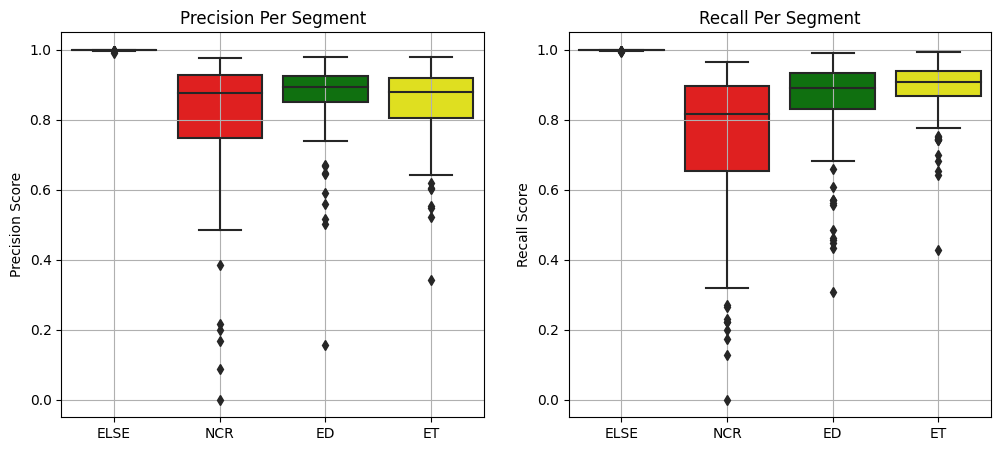

In [223]:
all_precision_np = np.array([metric['precision'] for metric in all_common_metrics])
all_recall_np = np.array([metric['recall'] for metric in all_common_metrics])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.boxplot(data=all_precision_np,  palette=segment_colors, ax=axs[0])
sns.boxplot(data=all_recall_np,  palette=segment_colors, ax=axs[1])

axs[0].set_xticks(range(len(segment_ids)), segment_names)
axs[0].set_ylabel("Precision Score")
axs[0].set_title("Precision Per Segment")
axs[0].grid(True)

axs[1].set_xticks(range(len(segment_ids)), segment_names)
axs[1].set_ylabel("Recall Score")
axs[1].set_title("Recall Per Segment")
axs[1].grid(True)
plt.show()

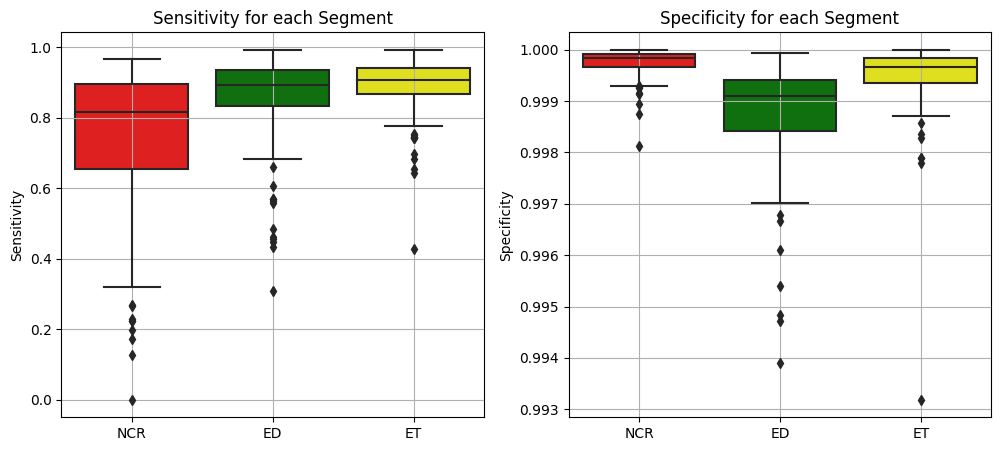

In [224]:
sensitivity_np = np.array([metric['sensitivity'] for metric in all_common_metrics])
specificity_np = np.array([metric['specificity'] for metric in all_common_metrics])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.boxplot(data=sensitivity_np[:, 1:],  palette=segment_colors[1:], ax=axs[0])
sns.boxplot(data=specificity_np[:, 1:],  palette=segment_colors[1:], ax=axs[1])

axs[0].grid(True)
axs[0].set_xticks(range(len(segment_ids)-1), segment_names[1:])
axs[0].set_ylabel("Sensitivity")
axs[0].set_title("Sensitivity for each Segment")
axs[1].grid(True)
axs[1].set_xticks(range(len(segment_ids)-1), segment_names[1:])
axs[1].set_ylabel("Specificity")
axs[1].set_title("Specificity for each Segment")

plt.show()

### DICE SCORE

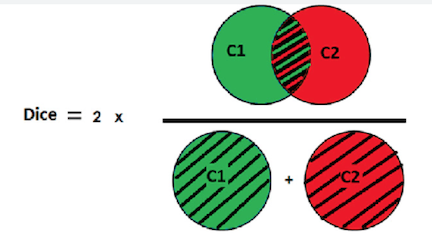

In [225]:
all_dice_np = np.array(all_dice)

In [226]:
dice_df = pd.DataFrame(all_dice_np, columns=segment_names)
dice_df.describe()[segment_names[1:]]

,NCR,ED,ET
count,146.000000,146.000000,146.000000
mean,0.759499,0.856041,0.864639
std,0.191194,0.108091,0.076197
min,0.000000,0.246763,0.496126
25%,0.692616,0.841408,0.836163
50%,0.820174,0.881181,0.880909
75%,0.893082,0.919323,0.908471
max,0.970380,0.963036,0.969159


#### DICE SCORE PER SEGMENT

ED has the lowest (LABEL 1)

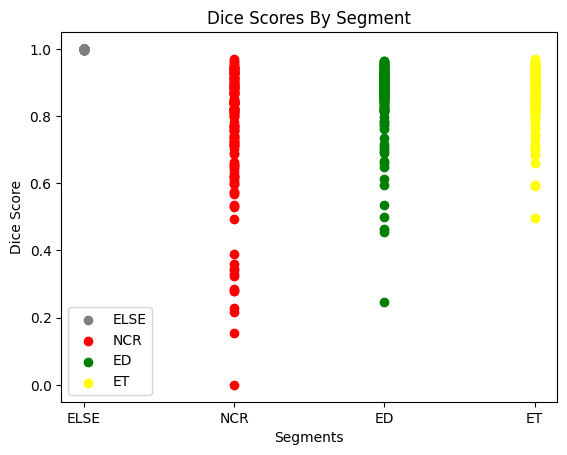

In [227]:
# Plot the dice scores as a scatter plot
for idx in range(len(segment_ids)):
  dice_scores = np.array(all_dice)[:, idx]
  label = segment_ids[idx]
  x_val = [label] * len(dice_scores)

  plt.scatter(x_val, dice_scores, label=f"{segment_names[idx]}", color=segment_colors[idx])
  plt.xlabel('Segments')
  plt.ylabel('Dice Score')
  plt.title('Dice Scores By Segment')
  plt.legend()

plt.xticks(segment_ids, segment_names)
plt.show()

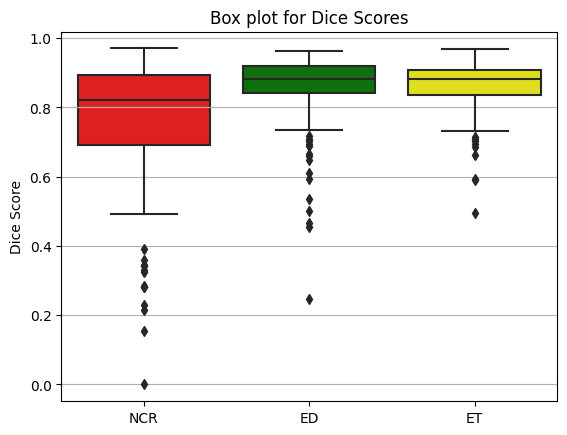

In [228]:
### Statistics
sns.boxplot(data=all_dice_np[:, 1:],  palette=segment_colors[1:])
plt.xticks(range(len(segment_ids)-1), segment_names[1:])
plt.ylabel("Dice Score")
plt.title("Box plot for Dice Scores")
plt.grid(axis="y")
plt.show()

#### DICE SCORE FOR EACH FILE

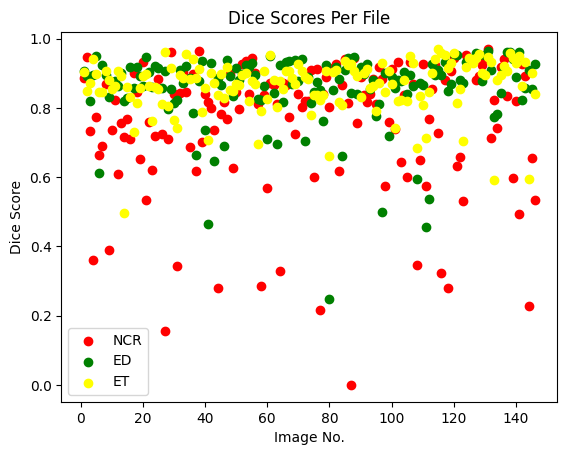

In [229]:
scores_len = len(all_dice)

for segm_idx in range(1, len(segment_ids)):
  dice_scores = all_dice_np[:, segm_idx]
  plt.scatter(np.arange(1, scores_len+1), dice_scores, color=segment_colors[segm_idx], label=f"{segment_names[segm_idx]}")

plt.xlabel('Image No.')
plt.ylabel('Dice Score')
plt.title('Dice Scores Per File')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend()
plt.show()

#### DICE SCORE HISTOGRAM

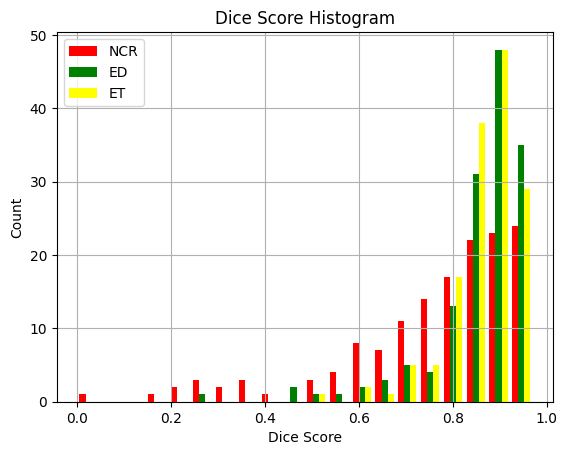

In [230]:
# Make a separate list for each segment
x2 = all_dice_np[:, 1]
x3 = all_dice_np[:, 2]
x4 = all_dice_np[:, 3]

# Assign colors for each segment and the names
colors = np.array(list(mri_common.SEGMENT_COLORS.values()))
names = segment_names

plt.hist([x2, x3, x4], bins = 20, color = segment_colors[1:], label=names[1:])
plt.legend()
plt.xlabel('Dice Score')
plt.ylabel('Count')
plt.grid(True)
plt.title('Dice Score Histogram')
plt.show()

#### PLOT IMAGES WITH THE LOWEST DICE SCORES

In [258]:
# Flatten the array
flattened_array = all_dice_np.flatten()

# rearranges the elements such that the smallest 10 elements come before the 10th index
top_10_idx_1d = np.argpartition(flattened_array, kth=10)[:10]

# Reshape the indices back to the original 2D shape to get row (file number) and col (segment)
top_10_indices = np.unravel_index(top_10_idx_1d, all_dice_np.shape)

top_10_values = all_dice_np[top_10_indices]
top_10_worst_dice = list(zip(top_10_indices[0], top_10_indices[1], top_10_values))
top_10_worst_dice_sorted = sorted(top_10_worst_dice, key=lambda x: x[2])

In [259]:
plot_samples(subj_files_np, top_10_worst_dice_sorted)

Output hidden; open in https://colab.research.google.com to view.

### HAUSDORFF DISTANCE

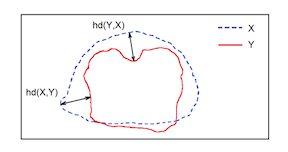

In [233]:
# replace None values with highest hd95
max_value = 0
none_indices = []
for subj_idx, hd95_per_subj in enumerate(all_hd95):
  for segm_idx, hd95 in enumerate(hd95_per_subj):
    if hd95 is None or hd95 == np.inf:
      none_indices.append((subj_idx, segm_idx))
    else:
      if hd95 > max_value:
        max_value = hd95

print("max hausdorff", str(max_value))
print(none_indices)

max hausdorff 19.712929453234015
[(86, 1)]


In [234]:
for row, col in none_indices:
  all_hd95[row][col] = max_value + 1

In [235]:
all_hd95_np = np.array(all_hd95)
hd95_df = pd.DataFrame(all_hd95_np, columns=segment_names).astype(float)
hd95_df.isnull().sum()

ELSE    0
NCR     0
ED      0
ET      0
dtype: int64

In [236]:
hd95_df.describe()[segment_names[1:]]

,NCR,ED,ET
count,146.000000,146.000000,146.000000
mean,2.845788,2.565015,1.424394
std,2.935253,2.625237,1.762371
min,1.000000,1.000000,1.000000
25%,1.414214,1.414214,1.000000
50%,2.236068,1.732051,1.000000
75%,3.162278,2.733693,1.000000
max,20.712929,17.029386,18.248267


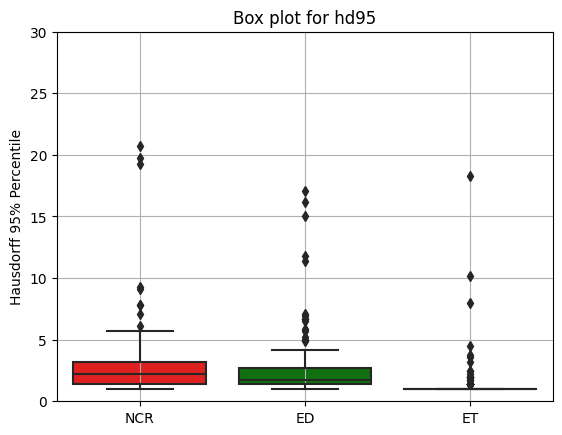

In [237]:
### Statistics
sns.boxplot(data=all_hd95_np[:,1:], palette=segment_colors[1:])
plt.xticks(range(len(segment_ids)-1), segment_names[1:])
plt.ylabel("Hausdorff 95% Percentile")
plt.title("Box plot for hd95")
plt.ylim(0, 30)
plt.grid(True)
plt.show()

#### HAUSDORFF DISTANCES PER SEGMENT

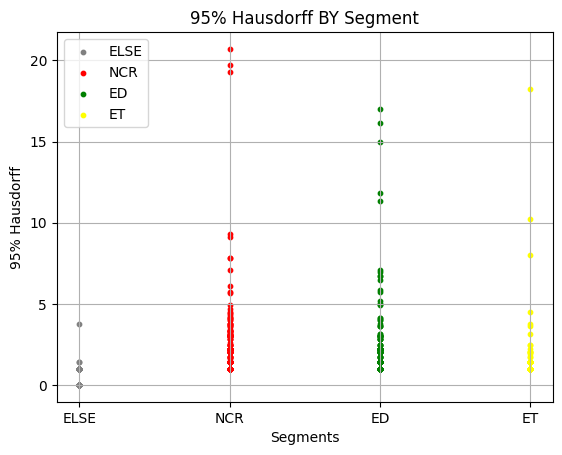

In [256]:
# Plot hausdorff scores as a scatter plot
for idx in range(len(segment_ids)):
  y_val = all_hd95_np[:, idx]
  label = segment_ids[idx]
  x_val = [label] * len(y_val)

  plt.scatter(x_val, y_val, label=f"{segment_names[idx]}", color=segment_colors[idx], s=10)

plt.xlabel('Segments')
plt.ylabel('95% Hausdorff')
plt.title('95% Hausdorff BY Segment')

plt.legend()
plt.grid(True)
plt.xticks(segment_ids, segment_names)
plt.show()

#### HAUSDORFF DISTANCES PER FILE

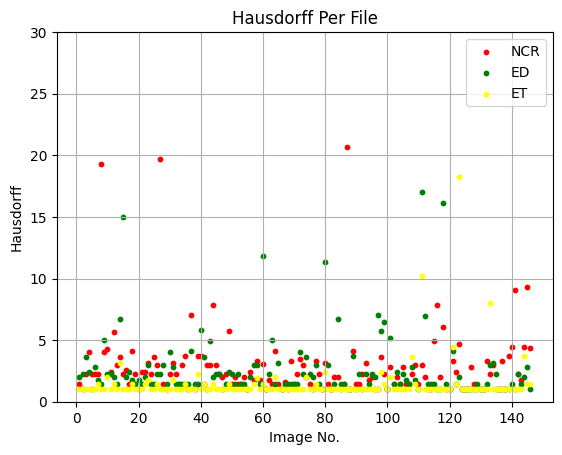

In [239]:
scores_len = len(all_hd95)

for segm_idx in range(1, len(segment_ids)):
  dice_scores = all_hd95_np[:, segm_idx]
  plt.scatter(np.arange(1, scores_len+1), dice_scores, color=segment_colors[segm_idx],
              label=f"{segment_names[segm_idx]}", s=10)

plt.xlabel('Image No.')
plt.ylabel('Hausdorff')
plt.title('Hausdorff Per File')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# hide outlier
plt.ylim(0, 30)
plt.grid(True)
plt.legend()
plt.show()

#### HAUSDORFF HISTOGRAM

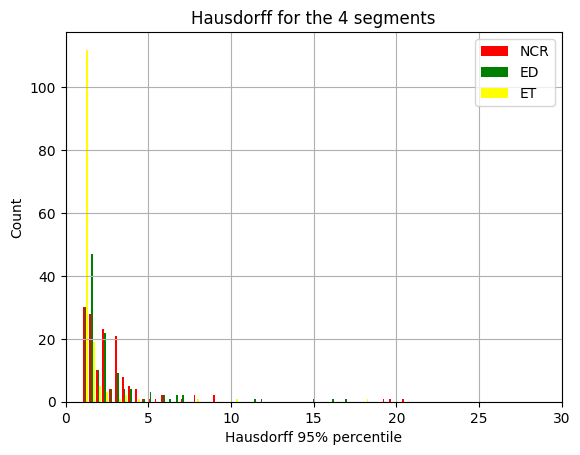

In [240]:
# Make a separate list for each segment
x2 = all_hd95_np[:, 1]
x3 = all_hd95_np[:, 2]
x4 = all_hd95_np[:, 3]

# Assign colors for each airline and the names
plt.hist([x2, x3, x4], bins = 50, color = segment_colors[1:], label=segment_names[1:])
plt.legend()
plt.xlim(0, 30)
plt.xlabel('Hausdorff 95% percentile')
plt.ylabel('Count')
plt.title('Hausdorff for the 4 segments')
plt.grid(True)
plt.show()

#### PLOT IMAGES WITH HIGHEST HD95 SCORE

In [260]:
# Get 10 images with lowest hausdorff distance
# Flatten the array
flattened_array = all_hd95_np.flatten()

# Find the indices of the top 10 largest numbers
top_10_idx_1d = np.argpartition(flattened_array, kth=-10)[-10:]

# Reshape the indices back to the original 2D shape
top_10_indices = np.unravel_index(top_10_idx_1d, all_hd95_np.shape)
top_10_values = all_hd95_np[top_10_indices]
top_10_worst_hd = list(zip(top_10_indices[0], top_10_indices[1], top_10_values))
top_10_worst_hd_sorted = sorted(top_10_worst_hd, key=lambda x: -x[2])

In [261]:
plot_samples(subj_files_np, top_10_worst_hd_sorted)

Output hidden; open in https://colab.research.google.com to view.

### SAVE RESULTS

In [243]:
# Save to file
worst_dice_subj_idx = list(zip(*top_10_worst_dice_sorted))[0]
worst_dice_subj_names = subj_files_np[list(worst_dice_subj_idx)]
top_10_worst_dice_sorted_dict = []
for idx, subj in enumerate(worst_dice_subj_names):
  subj_idx, segm, score = top_10_worst_dice_sorted[idx]
  top_10_worst_dice_sorted_dict.append(
      {
          "subj": subj,
          "label": segm,
          "score": score
      }
  )
top_10_worst_dice_sorted_dict

[{'subj': 'UPENN-GBM-00201_11', 'label': 1, 'score': 0.0},
 {'subj': 'UPENN-GBM-00069_11', 'label': 1, 'score': 0.15544041450777202},
 {'subj': 'UPENN-GBM-00173_11', 'label': 1, 'score': 0.21587743732590528},
 {'subj': 'UPENN-GBM-00438_11', 'label': 1, 'score': 0.22878228782287824},
 {'subj': 'UPENN-GBM-00178_11', 'label': 2, 'score': 0.24676313785224677},
 {'subj': 'UPENN-GBM-00307_11', 'label': 1, 'score': 0.28013029315960913},
 {'subj': 'UPENN-GBM-00107_11', 'label': 1, 'score': 0.2804938271604938},
 {'subj': 'UPENN-GBM-00135_11', 'label': 1, 'score': 0.2851153039832285},
 {'subj': 'UPENN-GBM-00290_11', 'label': 1, 'score': 0.3240506329113924},
 {'subj': 'UPENN-GBM-00141_11', 'label': 1, 'score': 0.32926233512457254}]

In [244]:
worst_hd_subj_idx = list(zip(*top_10_worst_hd_sorted))[0]
worst_hd_subj_names = subj_files_np[list(worst_hd_subj_idx)]
top_10_worst_hd_sorted_dict = []
for idx, subj in enumerate(worst_hd_subj_names):
  subj_idx, segm, score = top_10_worst_hd_sorted[idx]
  top_10_worst_hd_sorted_dict.append(
      {
          "subj": subj,
          "label": segm,
          "score": score
      }
  )
top_10_worst_hd_sorted_dict

[{'subj': 'UPENN-GBM-00201_11', 'label': 1, 'score': 20.712929453234015},
 {'subj': 'UPENN-GBM-00069_11', 'label': 1, 'score': 19.712929453234015},
 {'subj': 'UPENN-GBM-00016_11', 'label': 1, 'score': 19.261360284258224},
 {'subj': 'UPENN-GBM-00356_11', 'label': 3, 'score': 18.24826702039283},
 {'subj': 'UPENN-GBM-00274_11', 'label': 2, 'score': 17.029386365926403},
 {'subj': 'UPENN-GBM-00307_11', 'label': 2, 'score': 16.147749690201906},
 {'subj': 'UPENN-GBM-00030_11', 'label': 2, 'score': 15.0},
 {'subj': 'UPENN-GBM-00137_11', 'label': 2, 'score': 11.832159566199232},
 {'subj': 'UPENN-GBM-00178_11', 'label': 2, 'score': 11.357816691600547},
 {'subj': 'UPENN-GBM-00274_11', 'label': 3, 'score': 10.198039027185569}]

In [245]:
# Create temp files
worst_dice_temp_file = data_handler.create_temp_file(worst_dice_file_name)
print(worst_dice_temp_file)

worst_hd95_temp_file = data_handler.create_temp_file(worst_hd_file_name)
print(worst_hd95_temp_file)

/tmp/tmpwihg5al0.joblib
/tmp/tmp6ipvo__q.joblib


In [246]:
# dump data into the temp files
joblib.dump(top_10_worst_dice_sorted_dict, worst_dice_temp_file)
joblib.dump(top_10_worst_hd_sorted_dict, worst_hd95_temp_file)

['/tmp/tmp6ipvo__q.joblib']

In [247]:
# save to cloud
data_handler.save_from_source_path(file_name=worst_dice_file_name, source_path=worst_dice_temp_file,
                                   train_dir_prefix="metrics", use_cloud=True)
data_handler.save_from_source_path(file_name=worst_hd_file_name, source_path=worst_hd95_temp_file,
                                   train_dir_prefix="metrics", use_cloud=True)

### COMPARE SCORES BETWEEN ORIGINAL AND REDUCED

verified that the scores are the same with original vs reduced

In [248]:
worst_dice_original_fname = data_handler.load_to_temp_file(file_name="worst_dice.joblib", train_dir_prefix="metrics")
worst_dice_reduced_fname = data_handler.load_to_temp_file(file_name="worst_dice-2.joblib", train_dir_prefix="metrics")

worst_hd_original_fname = data_handler.load_to_temp_file(file_name="worst_hd95.joblib", train_dir_prefix="metrics")
worst_hd_reduced_fname = data_handler.load_to_temp_file(file_name="worst_hd95-2.joblib", train_dir_prefix="metrics")

In [249]:
# load from temp files:
worst_dice_original = joblib.load(worst_dice_original_fname)
worst_dice_original

[{'subj': 'UPENN-GBM-00201_11', 'label': 1, 'score': 0.0},
 {'subj': 'UPENN-GBM-00069_11', 'label': 1, 'score': 0.15544041450777202},
 {'subj': 'UPENN-GBM-00173_11', 'label': 1, 'score': 0.21587743732590528},
 {'subj': 'UPENN-GBM-00438_11', 'label': 1, 'score': 0.22878228782287824},
 {'subj': 'UPENN-GBM-00178_11', 'label': 2, 'score': 0.24676313785224677},
 {'subj': 'UPENN-GBM-00307_11', 'label': 1, 'score': 0.28013029315960913},
 {'subj': 'UPENN-GBM-00107_11', 'label': 1, 'score': 0.2804938271604938},
 {'subj': 'UPENN-GBM-00135_11', 'label': 1, 'score': 0.2851153039832285},
 {'subj': 'UPENN-GBM-00290_11', 'label': 1, 'score': 0.3240506329113924},
 {'subj': 'UPENN-GBM-00141_11', 'label': 1, 'score': 0.32926233512457254}]

In [250]:
worst_dice_reduced = joblib.load(worst_dice_reduced_fname)
worst_dice_reduced

[{'subj': 'UPENN-GBM-00201_11', 'label': 1, 'score': 0.0},
 {'subj': 'UPENN-GBM-00069_11', 'label': 1, 'score': 0.15544041450777202},
 {'subj': 'UPENN-GBM-00173_11', 'label': 1, 'score': 0.21587743732590528},
 {'subj': 'UPENN-GBM-00438_11', 'label': 1, 'score': 0.22878228782287824},
 {'subj': 'UPENN-GBM-00178_11', 'label': 2, 'score': 0.24676313785224677},
 {'subj': 'UPENN-GBM-00307_11', 'label': 1, 'score': 0.28013029315960913},
 {'subj': 'UPENN-GBM-00107_11', 'label': 1, 'score': 0.2804938271604938},
 {'subj': 'UPENN-GBM-00135_11', 'label': 1, 'score': 0.2851153039832285},
 {'subj': 'UPENN-GBM-00290_11', 'label': 1, 'score': 0.3240506329113924},
 {'subj': 'UPENN-GBM-00141_11', 'label': 1, 'score': 0.32926233512457254}]

In [251]:
worst_hd_original = joblib.load(worst_hd_original_fname)
worst_hd_original

[{'subj': 'UPENN-GBM-00201_11', 'label': 1, 'score': 20.712929453234015},
 {'subj': 'UPENN-GBM-00069_11', 'label': 1, 'score': 19.712929453234015},
 {'subj': 'UPENN-GBM-00016_11', 'label': 1, 'score': 19.261360284258224},
 {'subj': 'UPENN-GBM-00356_11', 'label': 3, 'score': 18.24826702039283},
 {'subj': 'UPENN-GBM-00274_11', 'label': 2, 'score': 17.029386365926403},
 {'subj': 'UPENN-GBM-00307_11', 'label': 2, 'score': 16.147749690201906},
 {'subj': 'UPENN-GBM-00030_11', 'label': 2, 'score': 15.0},
 {'subj': 'UPENN-GBM-00137_11', 'label': 2, 'score': 11.832159566199232},
 {'subj': 'UPENN-GBM-00178_11', 'label': 2, 'score': 11.357816691600547},
 {'subj': 'UPENN-GBM-00274_11', 'label': 3, 'score': 10.198039027185569}]

In [252]:
worst_hd_reduced = joblib.load(worst_hd_reduced_fname)
worst_hd_reduced

[{'subj': 'UPENN-GBM-00201_11', 'label': 1, 'score': 20.712929453234015},
 {'subj': 'UPENN-GBM-00069_11', 'label': 1, 'score': 19.712929453234015},
 {'subj': 'UPENN-GBM-00016_11', 'label': 1, 'score': 19.261360284258224},
 {'subj': 'UPENN-GBM-00356_11', 'label': 3, 'score': 18.24826702039283},
 {'subj': 'UPENN-GBM-00274_11', 'label': 2, 'score': 17.029386365926403},
 {'subj': 'UPENN-GBM-00307_11', 'label': 2, 'score': 16.147749690201906},
 {'subj': 'UPENN-GBM-00030_11', 'label': 2, 'score': 15.0},
 {'subj': 'UPENN-GBM-00137_11', 'label': 2, 'score': 11.832159566199232},
 {'subj': 'UPENN-GBM-00178_11', 'label': 2, 'score': 11.357816691600547},
 {'subj': 'UPENN-GBM-00274_11', 'label': 3, 'score': 10.198039027185569}]

In [253]:
# nrows=len(top_10_worst_hd_sorted)
# ncols=3

# mri_plt = MRIPlotter()
# fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7*ncols, 6*nrows))

# for idx, img_info in enumerate(top_10_worst_hd_sorted):

#   subj_file_idx, segment_idx, hd95 = img_info
#   subj_id = subj_files_np[subj_file_idx]
#   segment = segment_ids[segment_idx]
#   segment_name = segment_names[segment_idx]

#   # load flair image as base image
#   base_img = data_handler.load_mri(subj_id=subj_id,
#                                 mri_type=MriType.STRUCT_SCAN,
#                                 struct_scan=StructuralScan.FLAIR)

#   # load segmented and auto-segmented
#   true_img = data_handler.load_mri(subj_id=subj_id, mri_type=MriType.ANNOTATED)
#   pred_img = data_handler.load_mri(subj_id=subj_id, mri_type=MriType.AUTO_SEGMENTED)

#   # get binary mask for segment with lowest dice score
#   true_img_bin = (true_img == segment)
#   pred_img_bin = (pred_img == segment)

#   # get all surface distance
#   hd95, surface_dist_pred, surface_dist_true =  metrics.plot_hausdorff_95(pred_img, true_img, segm_id=segment)
#   surface_dist_pred_2 = convert_none_to_zero(surface_dist_pred)
#   surface_dist_true_2 = convert_none_to_zero(surface_dist_true)

#   # get appropriate slice from true image
#   z_idx = mri_common.get_largest_tumor_slice_idx(surface_dist_true_2, sum=True)[0]

#   # column 1 plot base image FLAIR and predicted mask
#   mri_plt.plot_struct_img(img_data=base_img, fig=fig, axs=axs, row=idx, col=0,
#                           title=f"{subj_id} - HD95: {round(hd95, 2)}", auto_cbar=False, slice_idx=z_idx)
#   mri_plt.plot_segm_img(img_data=true_img, fig=fig, axs=axs, row=idx, col=0, overlay=True, slice_idx=z_idx)


#   # column 2
#   mri_plt.plot_img(img_data=surface_dist_true_2, fig=fig, axs=axs, row=idx,
#                    col=1, title=f"Annotated - Surface Distance - {segment_name} - Slice {z_idx}", slice_idx=z_idx, cmap="cividis")

#   # column 3
#   z_idx_pred = mri_common.get_largest_tumor_slice_idx(surface_dist_pred_2, sum=True)[0]
#   mri_plt.plot_img(img_data=surface_dist_pred_2, fig=fig, axs=axs, row=idx,
#                    col=2, title=f"Predicted - Surface Distance - {segment_name} - Slice {z_idx_pred}", slice_idx=z_idx_pred, cmap="cividis")

# plt.show()